**1.Some income data, lognormal distribution, and hypothesis testing**

In [55]:
import pandas as pd
income = np.loadtxt("incomes.txt")


[ 51253.49715631 100630.32024137  83009.27613739  82882.10654304
  77338.29483892  81071.64131675  84760.04353269  74599.0967193
  94687.36110452  76720.48678222  84669.65776296  79707.04914362
 100026.64050846  89828.42639587  74006.05604302 103281.1855776
  88586.79236711 133631.92813961  91519.53047238 106863.33198279
  89622.32208316  63803.24097245  99116.670934   135865.02679613
  61344.18577082  99182.27630779  55038.04861413  71353.56078829
  90880.19896459  80950.37075039  84724.93806271  91236.88284731
  91628.21297882 105243.4671147   71500.93550933  56162.05440841
  78935.2939267   81097.09361259 130354.71406191 112159.02216504
  82259.96409801  75699.52604273  71699.30209176  93487.89133203
 120723.60773086 113045.98795795  70752.04409433 103679.41128338
  62517.62724779  70780.7133676  112840.45723451  65532.50301185
  69456.26059752  78471.04167764  76553.5638485   64774.04774462
  79461.70772595 108712.79343915 134832.20852612  52757.47937675
  83979.94687516  56981.252

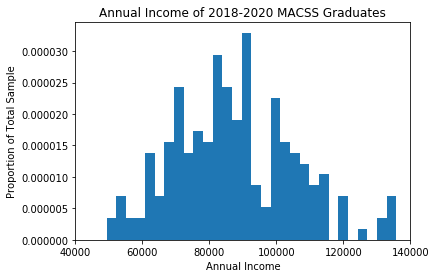

In [62]:
#a
import matplotlib.pyplot as plt
%matplotlib inline
num_bins = 30
count,bins,ignored = plt.hist(income, num_bins,normed=True)
plt.title("Annual Income of 2018-2020 MACSS Graduates")
plt.xlabel("Annual Income")
plt.ylabel("Proportion of Total Sample")
plt.xlim([40000, 140000])
plt.show()

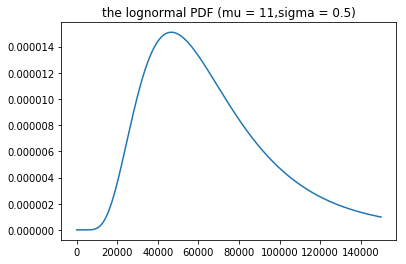

In [70]:
#b

import numpy as np
x = np.linspace(1e-4,150000,100000)
def lognorm(x,mu,sig):
    return 1/(x*sig * np.sqrt(2 * np.pi))*np.e**(-(np.log(x) - mu)**2 / (2 * sig**2))

plt.plot(x,lognorm(x,mu=11,sig=0.5))
plt.title("the lognormal PDF (mu = 11,sigma = 0.5)")
plt.show()


In [71]:
import scipy.stats as sts

def trunc_lognorm_pdf(x, mu, sig, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sig, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sig,scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sig,scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sig,scale=np.exp(mu)))
            
    pdf_vals = ((1/(x*sig * np.sqrt(2 * np.pi)) *
                np.exp( - (np.log(x) - mu)**2 / (2 * sig**2))) /
                prob_notcut)
    
    return pdf_vals 

def loglike_trunclognorm(x, mu, sig, cut_lb, cut_ub):

    pdf_vals = trunc_lognorm_pdf(x, mu, sig, cut_lb, cut_ub)
    ln_pdf_vals = np.log(pdf_vals)
    loglike_val = ln_pdf_vals.sum()
    
    return loglike_val

print(' the log likelihood value is:', loglike_trunclognorm(income, mu=11, sig=0.5,cut_lb=0, cut_ub=150000))


 the log likelihood value is: -2379.120591931827


In [86]:
#c
import scipy.optimize as opt
mu_init=11
sig_init=0.5
para_init=np.array([mu_init,sig_init])
mle_args=(income,0,150000)

def crit(parmts,*args):
    mu,sig=parmts
    x,cut_lb,cut_ub=args
    LL=loglike_trunclognorm(x,mu,abs(sig),cut_lb,cut_ub)
    neg_ll_val=-LL
    return neg_ll_val


result=opt.minimize(crit,para_init,args=(mle_args))
mu_est,sig_est=result.x

print("the estimated mu is:",mu_est)
print("the estimated sigma is:",sig_est)
print("the log likelihood value is:",loglike_truncnorm(income,mu_est,sig_est,0,150000))
print("the variance-covariance matrix is:",result.hess_inv)

the estimated mu is: 11.361699976140056
the estimated sigma is: 0.21174326472241192
the log likelihood value is: None
the variance-covariance matrix is: [[0.00032821 0.00066662]
 [0.00066662 0.00147221]]


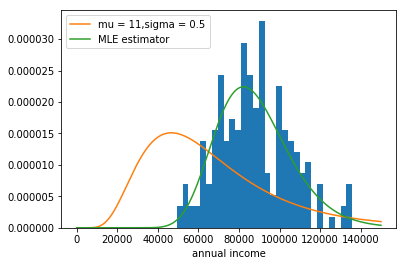

In [89]:
num_bins = 30
count,bins,ignored = plt.hist(income, num_bins,normed=True)
plt.plot(x,lognorm(x,mu=11,sig=0.5),label="mu = 11,sigma = 0.5")
plt.plot(x,lognorm(x,mu=mu_est,sig=sig_est),label="MLE estimator")
plt.xlabel("annual income")
plt.legend()
plt.show()

In [93]:
#d
mu_new, sig_new = np.array([11, 0.5])
log_lik_h0 = loglike_trunclognorm(income, mu_new, sig_new, 0, 150000)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = loglike_trunclognorm(income, mu_est, sig_est, 0, 150000)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2379.120591931827
MLE log likelihood -2240.934337511636
likelihood ratio value 276.3725088403826
chi squared of H0 with 2 degrees of freedom p-value =  0.0


p-value is very close to zero, therefore we can reasonably reject the null hypothesis that the data comes from is the model in which mu=11,sigma=0.5

In [95]:
#e
print("the probability that I will earn more than $100,000:",1-sts.lognorm.cdf(100000, sig_est, scale=np.exp(mu_est))) 
print("the probability that I will earn less than $75,000:", sts.lognorm.cdf(75000,sig_est,scale=np.exp(mu_est)))


the probability that I will earn more than $100,000: 0.23755402258976566
the probability that I will earn less than $75,000: 0.2596439222572218


**2.Linear regression and MLE**

In [106]:
sick=pd.read_csv("sick.txt")

In [110]:
#a
def norm_pdf(xvals, sig):
    sig=abs(sig)
    pdf_vals = (1/(sig*np.sqrt(2*np.pi)))*np.exp(-(xvals)**2 / (2*sig**2))                  
    return pdf_vals

def log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sig):
    
    err=y-b0-b1*x1-b2*x2-b3*x3
    pdf_vals = norm_pdf(err, sig)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit2(params,*args):
    
    b0, b1, b2, b3, sig = params
    y, x1, x2, x3 = args
    log_lik_val = log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sig)
    neg_log_lik_val = -log_lik_val 
    
    return neg_log_lik_val

b0_init, b1_init, b2_init, b3_init, sig_init = (0.3,0.3,0.2,0.1,1)
y=sick['sick']
x1, x2, x3 = sick['age'], sick['children'], sick['avgtemp_winter']
params_init = np.array([b0_init, b1_init, b2_init, b3_init, sig_init])
results = opt.minimize(crit2, params_init,(y, x1, x2, x3))
b0_est, b1_est, b2_est, b3_est, sig_est = results.x
LL_est=-results.fun
print('beta 0=', b0_est)
print('beta 1=', b1_est)
print('beta 2=', b2_est)
print('beta 3=', b3_est)
print('sigma=', sig_est)
print("Value of the log likelihood function:",LL_est)
print(' the estimated variance covariance matrix of the estimates:', results.hess_inv)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero e

beta 0= 0.2516463718310378
beta 1= 0.012933350779986119
beta 2= 0.40050203860631045
beta 3= -0.009991673217542055
sigma= 0.003017683026813868
Value of the log likelihood function: 876.8650464335163
 the estimated variance covariance matrix of the estimates: [[ 8.05391939e-07  9.71035750e-09 -1.82193863e-07 -2.00286870e-08
  -4.74676588e-09]
 [ 9.71035750e-09  3.60002497e-09 -3.15149964e-08 -2.31661314e-09
   3.56176950e-10]
 [-1.82193863e-07 -3.15149964e-08  3.15114478e-07  2.08224080e-08
  -5.92877946e-09]
 [-2.00286870e-08 -2.31661314e-09  2.08224080e-08  1.79792868e-09
  -1.24479835e-10]
 [-4.74676588e-09  3.56176950e-10 -5.92877946e-09 -1.24479835e-10
   2.08654310e-08]]


In [112]:
#b
LL_new=log_lik_norm(y,x1,x2,x3,b0=1,b1=0,b2=0,b3=0,sig=0.1)
print('hypothesis value log likelihood', LL_new)
print('MLE log likelihood', LL_est)
LR_val=2*(LL_est-LL_new)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 5)
print('chi squared of H0 with 5 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2253.700688042125
MLE log likelihood 876.8650464335163
likelihood ratio value 6261.131468951283
chi squared of H0 with 5 degrees of freedom p-value =  0.0


 The likelihood that age, number of children, and average winter temperature have no eﬀect on the number of sick days is very close to zero.